... Reading file data ...
... Locating beacons ...
... Positions from IMU ...
... Calculating attitude using Madgwick ...


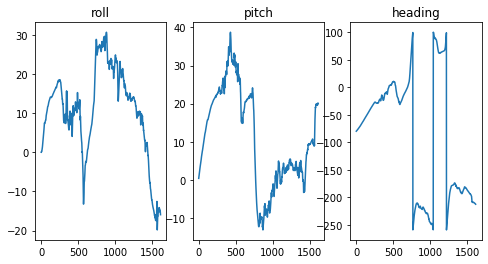

... Detecting steps ...


C:\Users\999mg\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:507: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000001EBBFD1DB08>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


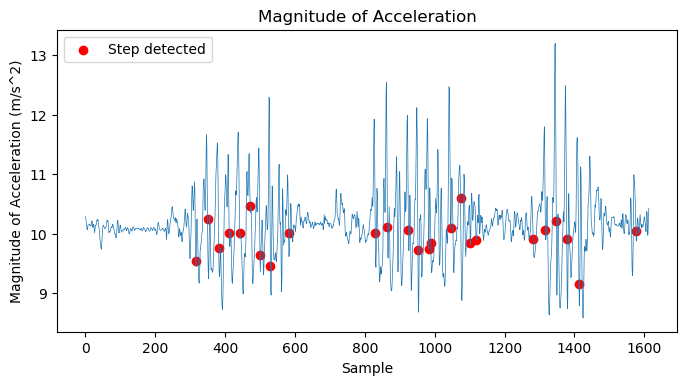

Number of steps:  25


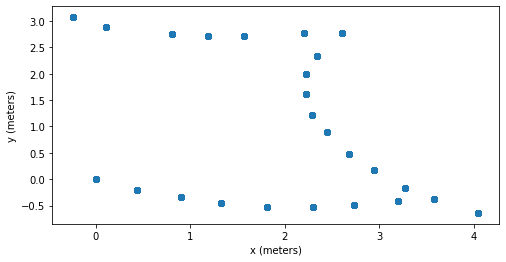

... Positions of BLE Beacons ...


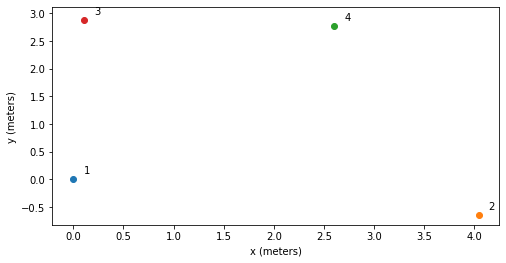

In [8]:

# Mapping 
# Using IMU to locate beacons
# ECE M202A Final Project - Max Gong - Fall 2020

#########################################################################################################

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import time
import math
from scipy.optimize import minimize
from IPython.display import display, clear_output

from skinematics.sensors.manual import MyOwnSensor
from skinematics.quat import Quaternion
from scipy.spatial.transform import Rotation as ScipyRotation

from ahrs.filters import Complementary, Madgwick

import socket

#########################################################################################################
 
readFile = 1                                         # readFile == 0 when want to read live UDP data, readFile == 1 when want to read pre-stored data
                                                     # Currently, the file is [up, left, up]
dataNumber = 11
methodMain = "Madgwick"
fileNamedataTime = 'dataTime' + str(dataNumber) + '.txt'
fileNamedataAcc  = 'dataAcc' + str(dataNumber) + '.txt'
fileNamedataGyr  = 'dataGyr' + str(dataNumber) + '.txt'
fileNamedataMag  = 'dataMag' + str(dataNumber) + '.txt'
fileNamedataBLE  = 'dataBLE' + str(dataNumber) + '.txt'
fileNamebeaconLocations = 'beaconLocations' + str(dataNumber) + '.txt'
fileNamepositions = 'positions'+str(dataNumber)
    
numOfBeacons = 4                                     # [ENTER NUMBER OF BEACONS HERE]

dataRate = 50
dataTime = np.zeros(1)
dataAcc = np.zeros((1,3))
dataGyr = np.zeros((1,3))
dataMag = np.zeros((1,3))
dataBLE = np.zeros(1)
    
    
#########################################################################################################
## Big functions ##
#########################################################################################################
        
        
## Read data from file, pre-collected data
def read_data_file():
    print("... Reading file data ...")
    dataTime = np.loadtxt(fileNamedataTime)
    dataAcc = np.loadtxt(fileNamedataAcc)
    dataGyr = np.loadtxt(fileNamedataGyr)
    dataMag = np.loadtxt(fileNamedataMag)
    dataBLE = np.loadtxt(fileNamedataBLE)
    return dataTime, dataAcc, dataGyr, dataMag, dataBLE


## Read data through UDP
def read_data_UDP():
    PORT = 12345            # arbitrary, just make it match in Android code
    IP = "0.0.0.0"          # represents IP address of phone

    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # UDP
    sock.bind((IP, PORT))
    
    fileTime = open(fileNamedataTime,"w")
    fileAcc = open(fileNamedataAcc,"w")                 # Open new file OR rewrite over existing file
    fileGyr = open(fileNamedataGyr,"w")
    fileMag = open(fileNamedataMag,"w")
    fileBLE = open(fileNamedataBLE,"w")
    dataTime = np.zeros(1)
    dataAcc = np.zeros((1,3))
    dataGyr = np.zeros((1,3))
    dataMag = np.zeros((1,3))
    dataBLE = np.zeros(1)
    counter = 0
    registerBeaconID = 0
    
    print("Waiting for data UDP...")
    try:
        while True:         
            msg_MB_content, addr = sock.recvfrom(1024)      # buffer size is 1024 bytes
            msg_MB_content = msg_MB_content.decode("utf-8")
            #print(msg_MB_content)
            if msg_MB_content.find('Stop') != -1:
                break
            elif msg_MB_content != "" and msg_MB_content.find('null') == -1 and msg_MB_content.find('paho') == -1:             
                data = np.asarray(msg_MB_content.split(","))       # Convert string of data into array 
                if counter != 0:                                   # Collect & store temporary data (but not the 1st data point, which may contain 'null')
                    for i in range(len(data)):
                        if i == 0: 
                            timeStamp = data[0]                    # milliseconds
                        elif i == 1: 
                            acc_x = float(data[1])
                        elif i == 2: 
                            acc_y = float(data[2])
                        elif i == 3:
                            acc_z = float(data[3])
                        elif i == 4 and data[i] != 'null':
                            gyr_x = float(data[4])
                        elif i == 5 and data[i] != 'null':
                            gyr_y = float(data[5])
                        elif i == 6 and data[i] != 'null':
                            gyr_z = float(data[6])
                        elif i == 7 and data[i] != 'null':
                            mag_x = float(data[7])
                        elif i == 8 and data[i] != 'null':
                            mag_y = float(data[8])
                        elif i == 9 and data[i] != 'null':
                            mag_z = float(data[9])
                        elif i == 10:
                            registerBeaconID = int(data[10])                               # Register the beacon when user hits "Activate Beacon" button 
                            print(str(registerBeaconID))
                    fileTime.write(str(timeStamp)+"\n")                                # Record timestamp into file
                    fileAcc.write(str(acc_x)+" "+str(acc_y)+" "+str(acc_z)+"\n")       # Record IMU into file
                    fileGyr.write(str(gyr_x)+" "+str(gyr_y)+" "+str(gyr_z)+"\n")
                    fileMag.write(str(mag_x)+" "+str(mag_y)+" "+str(mag_z)+"\n")
                    fileBLE.write(str(registerBeaconID)+"\n")                         # Record BLE beacon ID into file
                    if counter == 1:
                        dataTime = np.asarray([timeStamp])
                        dataAcc = [np.asarray([acc_x, acc_y, acc_z])]
                        dataGyr = [np.asarray([gyr_x, gyr_y, gyr_z])]
                        dataMag = [np.asarray([mag_x, mag_y, mag_z])]  
                        dataBLE = np.asarray([registerBeaconID])
                    else:
                        dataTime = np.vstack((dataTime, timeStamp))
                        dataAcc = np.vstack((dataAcc, np.asarray([acc_x, acc_y, acc_z])))
                        dataGyr = np.vstack((dataGyr, np.asarray([gyr_x, gyr_y, gyr_z])))
                        dataMag = np.vstack((dataMag, np.asarray([mag_x, mag_y, mag_z]))) 
                        dataBLE = np.vstack((dataBLE, registerBeaconID))
                counter += 1               # Update counter 
                registerBeaconID = 0       # Reset
                msg_MB_content = ""        # Reset 
    except KeyboardInterrupt:
        print("... Received keyboard interrupt ...")
        
    fileTime.close()
    fileAcc.close()
    fileGyr.close()
    fileMag.close()
    fileBLE.close()
    sock.close()
    print("... Finished reading UDP ...")      
    return dataTime, dataAcc, dataGyr, dataMag, dataBLE


## Locate position of beacons // possible methods to calculate heading -- Madgwick, EKF, Basic
def locate_beacons(dataRate, dataTime, dataAcc, dataGyr, dataMag, dataBLE, method="Madgwick"):
    print("... Locating beacons ...")
    positionsBeacon = np.zeros((1,2))                                                                   # Initialize positions    
    positions       = trace_IMU(dataRate, dataTime, dataAcc, dataGyr, dataMag, dataBLE, method=method)  # process IMU data to trace IMU path
    positionsBeacon = trace_BLE(positions, dataBLE, method=method)                                      # Determine BLE locations   
    return positionsBeacon


## Trace path of IMU positions
def trace_IMU(dataRate, dataTime, dataAcc, dataGyr, dataMag, dataBLE, method="Madgwick"):
    print("... Positions from IMU ...")  
    global fileNamepositions
    fileNamepositions = fileNamepositions + method + '.txt'                         # initialize files to write to
    filePositions = open(fileNamepositions, "w")
    if method == "EKF":
        roll, pitch, heading = calculate_attitude_EKF(dataRate, dataAcc, dataGyr, dataMag)
    elif method == "Basic":
        roll, pitch, heading = calculate_attitude_Basic(dataRate, dataAcc, dataGyr, dataMag) 
    else:
        roll, pitch, heading = calculate_attitude_Madgwick(dataRate, dataAcc, dataGyr, dataMag)
    positions, steps = step_detection_2(dataRate, dataAcc, roll, pitch, heading)
    print('Number of steps: ', steps)
    map_trace(positions)
    for sampleNumber in np.arange(positions.shape[0]):
        filePositions.write(str(positions[sampleNumber,0]) + " " + str(positions[sampleNumber,1]) + "\n")
    filePositions.close()
    return positions


## Determine BLE beacon locations
def trace_BLE(positions, dataBLE, method):
    print("... Positions of BLE Beacons ...") 
    fileBeaconLocations = open(fileNamebeaconLocations, "w")                          # initialize files to write to 
    fileNameLocationMethod = 'beaconLocations' + str(dataNumber) + method + '.txt'
    fileLocationMethod = open(fileNameLocationMethod, "w")
    numSamples = positions.shape[0]
    positionsBeacon = []
    for sampleNumber in np.arange(numSamples):                                        # record BLE locations
        if dataBLE[sampleNumber] != 0:
            dataString = str(int(dataBLE[sampleNumber]))+" "+str(positions[sampleNumber,0])+" "+str(positions[sampleNumber,1])+"\n"
            positionsBeacon.append([ int(dataBLE[sampleNumber]), positions[sampleNumber,0], positions[sampleNumber,1] ]) 
            fileBeaconLocations.write(dataString)
            fileLocationMethod.write(dataString)
    positionsBeacon = np.asarray(positionsBeacon)
    fileBeaconLocations.close()
    fileLocationMethod.close()
    return positionsBeacon
       
    
    
#########################################################################################################
## Smaller functions ##
#########################################################################################################

## Moving average filter for Accelerometer data
def filter_acc(rate, acc): 
    N = 5
    accFilt = np.zeros(acc.shape)
    for i in np.arange(3):                            # acc_x, acc_y, acc_z
        j = 0
        while j < len(acc[:,i]):
            if j < len(acc[:,i]) - N + 1:             # apply moving average, if window fits
                window = acc[j:j+N, i]
                accFilt[j,i] = sum(window) / N
            else:                                     # just copy raw values, if window doesn't fit
                accFilt[j,i] = acc[j,i]
            j += 1
    return accFilt


## convert Quaternion N-array (w,x,y,z) to euler angles     https://www.kaggle.com/c/career-con-2019/discussion/85303
def convertQuatToEuler(Q, rotate_heading):
    numSamples = Q.shape[0]
    euler = np.zeros((numSamples,3))
    for i in np.arange(numSamples): 
        w = Q[i, 0]
        x = Q[i, 1]
        y = Q[i, 2]
        z = Q[i, 3]
        sinr_cosp = 2 * (w * x + y * z)
        cosr_cosp = 1 - 2 * (x**2 + y**2)
        euler[i, 0] = np.arctan2(sinr_cosp, cosr_cosp)
        sinp = 2 * (w * y - z * x)
        euler[i, 1] = np.where(np.abs(sinp) >= 1, np.sign(sinp) * np.pi / 2, np.arcsin(sinp))
        siny_cosp = 2 * (w * z + x * y)
        cosy_cosp = 1 - 2 * (y**2 + z**2)
        euler[i, 2] = np.arctan2(siny_cosp, cosy_cosp)
    roll = euler[:,0]*180/np.pi
    pitch = euler[:,1]*180/np.pi
    heading = euler[:,2]*180/np.pi
    heading = heading + rotate_heading                 # rotate heading 
    return roll, pitch, heading


## plot roll, pitch, and heading
def plotEuler(roll, pitch, heading):
    rcParams['figure.figsize'] = 8,4
    fig, ax = plt.subplots(1,3)
    ax[0].plot(roll)
    ax[0].set_title('roll')
    ax[1].plot(pitch)
    ax[1].set_title('pitch')
    ax[2].plot(heading)
    ax[2].set_title('heading')
    plt.show()
    
    
## Calculate position from IMU data, using SCIKIT integrals over small time periods to avoid drift
def calculate_attitude_EKF(rate, acc, gyr, mag):
    print('... Calculating attitude using EKF ...')
    numSamples = acc.shape[0]                    # Calculate position over several time intervals (as opposed to the entire time length of data)
    #acc = filter_acc(rate, acc)                  # Filter accelerometer data
    in_data = {'rate': rate, 'acc': acc, 'omega': gyr, 'mag': mag}
    tempSensor = MyOwnSensor(q_type='kalman', in_data=in_data)
    Q = tempSensor.quat
    rotate_heading = 180
    roll, pitch, heading = convertQuatToEuler(Q, rotate_heading)
    plotEuler(roll, pitch, heading)
    return roll, pitch, heading


## Calculate heading USING https://github.com/Mayitzin/ahrs MADGWICK  https://www.x-io.co.uk/res/doc/madgwick_internal_report.pdf 
def calculate_attitude_Madgwick(rate, acc, gyr, mag):
    print('... Calculating attitude using Madgwick ...')
    numSamples = acc.shape[0]
    mag = mag/1000                                          # Convert uT to mT
    madgwick = Madgwick(frequency=rate)                       # Define Madgwick filter with rate = 50
    Q = np.tile([1., 0., 0., 0.], (numSamples, 1))          # Allocate an array for all quaternions (w,x,y,z)
    for i in np.arange(numSamples):
        Q[i] = madgwick.updateMARG(Q[i-1], gyr[i], acc[i], mag[i])
    rotate_heading = -80
    roll, pitch, heading = convertQuatToEuler(Q,rotate_heading)
    plotEuler(roll, pitch, heading)
    return roll, pitch, heading


## Calculate heading using basic techniques
def calculate_attitude_Basic(rate, acc, gyr, mag):
    print('... Calculating attitude using classic methods ...')
    numSamples = acc.shape[0]
    dt = 1/rate
    gyr = gyr*180/np.pi
    acc = acc/9.8
    accX = acc[:,0]
    accY = acc[:,1]
    accZ = acc[:,2]
    gyrX = gyr[:,0]
    gyrY = gyr[:,1]
    gyrZ = gyr[:,2]
    magX = mag[:,0]
    magY = mag[:,1]
    magZ = mag[:,2]
    pitch = np.arctan2(accY, (np.sqrt((accX**2)+(accZ**2))))*180/np.pi
    roll = np.arctan2(-accX, np.sqrt(accY**2 + accZ**2))*180/np.pi
    alpha = 0.95
    roll = alpha*gyrX*dt + (1-alpha)*roll
    pitch = alpha*gyrY*dt + (1-alpha)*pitch
    heading = np.arctan2( (-magY*np.cos(roll)+magZ*np.sin(roll)), (magX*np.cos(pitch)+magY*np.sin(pitch)*np.sin(roll)+magZ*np.sin(pitch)*np.cos(roll)))*180/np.pi
    heading = heading - 45               # rotate heading 
    plotEuler(roll, pitch, heading)
    return roll, pitch, heading

    
## Detect steps + stride length USING https://github.com/Takaklas/Indoor-Localization-WIth-IMU/blob/master/position_PDR.py    
def step_detection(rate, acc, roll, pitch, heading):
    print('... Detecting steps ...')
    fig=plt.figure(figsize=(8,4),dpi=100,facecolor='w',edgecolor='k')
    samplePeriod = 1/rate
    numSamples = acc.shape[0]
    accZ = acc[:,2]
    heading_quantized = np.zeros(heading.shape)
    heading_rad = np.zeros(heading.shape)
    for i in np.arange(numSamples):
        heading_quantized[i] = round(heading[i]/5) * 5
        heading_rad[i] = math.radians(heading_quantized[i])   
    alpha = 0.8
    threshold = 9.81
    sample_old = 9.81
    start_of_step = 0
    step_len = 0.3
    steps = 0
    new_max = 0
    new_min = 0
    minn = 20
    maxx = 0
    pitch_max = 0
    pitch_min = 0
    j = 0
    j_end = 0.5 / samplePeriod       # every 0.5 sec window, update the threshold
    updatePositionX = 0
    updatePositionY = 0
    
    positions = np.zeros((numSamples,2))
    
    for sampleNumber in np.arange(numSamples):       ## Run step detection
        
        acc_z = alpha*sample_old + (1-alpha)*accZ[sampleNumber]
        accZ[sampleNumber] = acc_z
        
        #start of new possible step
        if (acc_z > sample_old) and (acc_z > threshold) and (threshold > sample_old):
            start_of_step = sampleNumber
            pitch_max = pitch[sampleNumber]
            plt.scatter(sampleNumber,acc_z,color="orange")

        #check if we have a step
        if (acc_z < sample_old) and (acc_z < threshold) and (threshold < sample_old):
            end_of_step = sampleNumber
            pitch_min = pitch[sampleNumber]
            step_condition_1 = False
            step_condition_2 = False
            if end_of_step - start_of_step > (5*samplePeriod):       # condition_1 -- greater than 0.1 seconds
                step_condition_1 = True
            if (new_max - new_min) > 2:                              # condition_2 -- new max is much greater than new min
                step_condition_2 = True

            if step_condition_1 and step_condition_2:
                plt.scatter(sampleNumber,acc_z,color="red")
                step_len = 0.04 * (pitch_max - pitch_min) + 0.1                  # SLE based on pitch amplitude https://ieeexplore.ieee.org/document/7275473 
                updatePositionX = step_len * math.cos(heading_rad[sampleNumber])
                updatePositionY = step_len * math.sin(heading_rad[sampleNumber])
                steps += 1
            new_max = 0
            new_min = 20
        sample_old = acc_z            

        #update new_min, new_max for this step
        if (acc_z < new_min):
            new_min = acc_z
        elif (acc_z > new_max):
            new_max = acc_z

        #calculate min max for next threshold
        if (acc_z < minn):
            minn = acc_z
        elif (acc_z > maxx):
            maxx = acc_z
        j += 1
        
        #update threshold for next window
        if (j == j_end):
            threshold = (maxx + minn) / 2
            j = 0
            minn = 20
            maxx = 0
            plt.scatter(sampleNumber,threshold,color="black")
        
        # Update position for every sample
        if sampleNumber != 0:
            positions[sampleNumber,0] = positions[sampleNumber-1,0] + updatePositionX
            positions[sampleNumber,1] = positions[sampleNumber-1,1] + updatePositionY
            updatePositionX = 0
            updatePositionY = 0
    
    plt.plot(accZ,linewidth=0.5)
    plt.show()
    
    return positions, steps
    
    
## Detect steps + stride length USING StepDetectionAlgorithmforAccurateDistanceEstimationUsingDynamicStepLengthngth.pdf  
def step_detection_2(rate, acc, roll, pitch, heading):
    print('... Detecting steps ...')
    fig=plt.figure(figsize=(8,4),dpi=100,facecolor='w',edgecolor='k')
    heading_quantized = np.zeros(heading.shape)        # quantize heading to reduce inaccuracies
    heading_rad = np.zeros(heading.shape)              # convert heading from degree to radians
    numSamples = acc.shape[0]
    for i in np.arange(numSamples):
        heading_quantized[i] = round(heading[i]/5) * 5
        heading_rad[i] = math.radians(heading_quantized[i])   
    alpha = 0.75
    for i in np.arange(numSamples):                    # filter acceleration values
        if i != 0:
            acc[i] = alpha*acc[i-1] + (1-alpha)*acc[i]
    accMag = np.sqrt(np.square(acc[:,0]) + np.square(acc[:,1]) + np.square(acc[:,2]))
    samplePeriod = 1/rate
    threshold = 10
    sample_old = 9.81
    start_of_step = 0
    step_len = 0.3
    steps = 0
    new_max = 0
    new_min = 20
    minn = 20
    maxx = 0
    pitch_max = 0
    pitch_min = 0
    j = 0
    j_end = np.round(rate/2)                 # the window of no. of data points to re-evaluate threshold
    updatePositionX = 0
    updatePositionY = 0
    
    positions = np.zeros((numSamples,2))
    
    for sampleNumber in np.arange(numSamples):       ## Run step detection
        
        accMagnitude = accMag[sampleNumber]
        
        #start of new possible step
        if (accMagnitude > sample_old) and (accMagnitude > threshold) and (threshold > sample_old):
            start_of_step = sampleNumber
            #plt.scatter(sampleNumber,accMagnitude,color="orange")

        #check if we have a step
        if (accMagnitude < sample_old) and (accMagnitude < threshold) and (threshold < sample_old):
            end_of_step = sampleNumber
            step_condition_1 = False
            step_condition_2 = False
            if (end_of_step - start_of_step)/rate > 0.08:       # condition_1 -- greater than 0.1 seconds, to make sure it's not a fake step
                step_condition_1 = True
            if (new_max - new_min) > 0.7:                      # condition_2 -- new max is much greater than new min
                step_condition_2 = True

            if step_condition_1 and step_condition_2:
                PlotOfStep = plt.scatter(sampleNumber,accMagnitude,color="red")
                numSamplesinStep = end_of_step - start_of_step     # calculate stride length - "Predicting step time from step length and velocity" by Sandra Singleton    
                stepTime = numSamplesinStep*samplePeriod
                step_len = 0.7*stepTime + 0.3                    # calibrated stride_length - http://netlab.cs.ucla.edu/wiki/files/autogait.pdf -- 
                updatePositionX = step_len * math.cos(heading_rad[sampleNumber])
                updatePositionY = step_len * math.sin(heading_rad[sampleNumber])
                steps += 1
            new_max = 0
            new_min = 20
        sample_old = accMagnitude            

        #update new_min, new_max for this step
        if (accMagnitude < new_min):
            new_min = accMagnitude
        elif (accMagnitude > new_max):
            new_max = accMagnitude

        #calculate min max for next threshold
        if (accMagnitude < minn):
            minn = accMagnitude
        elif (accMagnitude > maxx):
            maxx = accMagnitude
        j += 1
        
        #update threshold for next window
        if (j == j_end):
            threshold = (maxx + minn) / 2
            j = 0
            minn = 20
            maxx = 0
            #plt.scatter(sampleNumber,threshold,color="black",s=10)
        
        # Update position for every sample
        if sampleNumber != 0:
            positions[sampleNumber,0] = positions[sampleNumber-1,0] + updatePositionX
            positions[sampleNumber,1] = positions[sampleNumber-1,1] + updatePositionY
            updatePositionX = 0
            updatePositionY = 0
    
    PlotOfAcc = plt.plot(accMag,linewidth=0.5)
    plt.legend((PlotOfStep, PlotOfAcc), ("Step detected", "Magnitude of Acceleration"))
    plt.title("Magnitude of Acceleration")
    plt.xlabel("Sample")
    plt.ylabel("Magnitude of Acceleration (m/s^2)")
    plt.show()
    
    return positions, steps
    
## Generate map of positions
def map_trace(positions):
    if positions.shape[0] != 0:
        xPos = positions[:,0]          # 1st column = x
        yPos = positions[:,1]          # 2nd column = y
        plt.scatter(xPos, yPos)
        plt.xlabel('x (meters)')
        plt.ylabel('y (meters)')
        plt.show()
    else:
        print("NO POSITIONS TO MAP")
        

## Generate map of beacons
def map_beacon_locations(positionsBeacon):
    if positionsBeacon.shape[0] != 0:
        ids = positionsBeacon[:,0]
        positions = positionsBeacon[:,[1,2]]
        for i in np.arange(positionsBeacon.shape[0]):
            x = positions[i,0]
            y = positions[i,1]
            plt.scatter(positions[i,0], positions[i,1])
            plt.annotate(str(int(ids[i])), (positions[i,0]+0.1, positions[i,1]+0.1))   # annotate IDs
        plt.xlabel('x (meters)')
        plt.ylabel('y (meters)')
        plt.show()
    else:
        print("NO BEACON POSITIONS TO MAP")

    
    
########################################################################################################
## RUN EVERYTHING ##
########################################################################################################

                                                                            # GET data
if readFile == 0:                                                           # if we want to collect live data through UDP
    dataTime, dataAcc, dataGyr, dataMag, dataBLE = read_data_UDP()  
else:                                                                       # if we want to use pre-collected data
    dataTime, dataAcc, dataGyr, dataMag, dataBLE = read_data_file()      
positionsBeacon = locate_beacons(dataRate, dataTime, dataAcc, dataGyr, dataMag, dataBLE, method=methodMain)       # LOCATE position of beacons
map_beacon_locations(positionsBeacon)                                           # MAP beacons





In [ ]:
import numpy as np

data = np.asarray([[1, 2, 3], [2, 3, 3]]) + [2, 2, 2]
print(data.shape[0])
print(data[data.shape[0]-1])
data = np.asarray([])
print(data.shape)

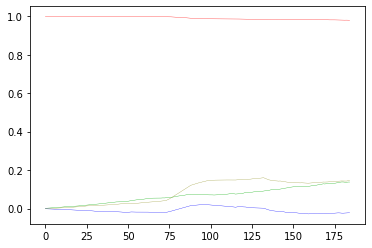

(185, 3)
(185,)
[ 0.20548221  0.27762424  0.35993186  0.38518372  0.4251161   0.49930441
  0.60270025  0.70606601  0.80940115  0.81018924  0.9276947   0.9893986
  1.09168697  1.12280662  1.15396082  1.1851496   1.22157012  1.33902517
  1.44112258  1.47749027  1.57949445  1.68137661  1.79870933  1.91063219
  2.01243411  2.08150659  2.20944378  2.3183765   2.42731933  2.49202904
  2.55682011  2.62169309  2.72267045  2.83724762  2.93819611  3.03205345
  3.13031133  3.26472163  3.40746455  3.50555116  3.64878791  3.7919346
  3.93499022  3.93711998  3.93916201  3.93885838  3.99524544  4.05161084
  4.10803641  4.16447769  4.35350988  4.54221092  4.73058005  4.86385754
  5.01064305  5.09517057  5.24178604  5.38829518  5.37103215  5.51737797
  5.69111742  5.83222287  5.91621011  6.00017609  6.08412064  6.16804365
  6.16754089  6.14962478  6.14911338  6.13113057  6.20054426  6.2698639
  6.25160893  6.32077013  6.38986559  6.45985997  6.56027754  6.75916674
  6.9595092   7.16128094  7.37189574  

In [13]:
import ahrs as ahrs
from scipy.spatial.transform import Rotation as ScipyRotation

dataAcc = np.loadtxt('dataAcc.txt')
dataGyr = np.loadtxt('dataGyr.txt')
dataMag = np.loadtxt('dataMag.txt')
numSamples = dataAcc.shape[0]

## Apply madgwick filter
madgwick = ahrs.filters.Madgwick() 
Q = np.tile([1., 0., 0., 0.], (numSamples, 1))            # Allocate an array for all quaternions
for i in np.arange(numSamples):
    Q[i] = madgwick.updateMARG(Q[i-1], dataGyr[i], dataAcc[i], dataMag[i])
    
ahrs.utils.plot_quaternions(Q)

## Obtain yaw from quarternion
euler = np.zeros((numSamples,3))
for i in np.arange(numSamples):
    euler[i] = (ScipyRotation.from_quat(Q[i])).as_euler('xyz', degrees=True)
heading = euler[:,2]
print(heading) 


In [3]:
import numpy as np

A = [[1, 2, 3], [2, 3, 5]]
print(A)


[[1, 2, 3], [2, 3, 5]]


In [41]:
from ahrs.filters import complementary

In [4]:
a = 1/50
print(a)

0.02
